In [1]:
import numpy as np
import math

from scipy.linalg import solve_triangular as scipy_solve_triangular
from scipy.linalg import qr as sp_qr
from scipy.linalg import solve_triangular as sp_solve_triangular
from scipy.sparse.linalg import SuperLU as sp_SuperLU
from scipy.sparse.linalg import cg as sp_cg
import scipy.sparse as sps

from scipy.stats import linregress

import jlinops


from jlinops import MatrixLinearOperator, _CustomLinearOperator 
from jlinops import banded_cholesky
from jlinops import DiagonalOperator
from jlinops import Neumann2D
from jlinops import dct_sqrt_pinv, dct_pinv
from jlinops import cg
from jlinops import issparse, tosparse, get_device
from jlinops import QRPinvOperator

import timeit
import time

from jlinops import CUPY_INSTALLED
if CUPY_INSTALLED:
    import cupy as cp
    from cupyx.scipy.linalg import solve_triangular as cp_solve_triangular
    from cupy.linalg import qr as cp_qr
    from cupyx.scipy.sparse.linalg import SuperLU as cp_SuperLU
    from cupyx.scipy.sparse.linalg import cg as cupy_cg
    from cupyx.profiler import benchmark


import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle


mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')



In [2]:
dcolors = {
    "dartmouth_green": "#00693e", 
    "forest_green": "#12312b",
    "river_blue": "#267aba",
    "autumn_brown": "#643c20",
    "bonfire_red": "#9d162e",
    "river_navy": "#003c73",
    "spring_green": "#c4dd88",
    "rich_spring_green": "#a5d75f",
    "summer_yellow": "#f5dc69",
    "bonfire_orange": "#ffa00f",
    "tuck_orange": "#e32d1c",
    "web_violet": "#8a6996",
    "midnight_black": "#000000",
}

In [2]:
# mpl.rcParams['text.usetex'] = True
# #mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')


In [3]:
# matplotlib.rcdefaults()

In [4]:
# Global parameters
N_SAMPLES = 50
LOW = 1
HIGH = 50
TOL = 1e-5

## Iteration experiment

### Preconditioned

In [5]:
top = 8
bottom = 2
diff = top-bottom
fac = 3
N1s = np.round(np.sqrt(np.logspace(bottom, top, fac*diff))).astype(np.int32)[:-1]
#N1s = np.round(np.sqrt(np.logspace(bottom, top, fac*diff))).astype(np.int32)[:-10]
print(N1s)

[  10   15   23   34   51   76  115  172  258  387  582  873 1311 1968
 2955 4437 6661]


In [6]:
preconditioned_mean_cg_its = []

cp.random.seed(0)

# Iterate over N
for N in N1s:
    print(N)

    it_counts = []
    for j in range(N_SAMPLES):

        w = cp.random.uniform(low=LOW, high=HIGH, size=2*N*N)
        Apinv = jlinops.CGWeightedNeumann2DPinvOperator((N,N), 1.0/np.sqrt(w) , tol=TOL)
        Apinv = Apinv.to_gpu()
        R = Neumann2D((N,N), device="gpu")
        WR = DiagonalOperator(1.0/cp.sqrt(w)) @ R 
        
        # Initialize a counter for the iterations
        global iteration_count
        iteration_count = 0

        # Define the callback function
        def callback(xk):
            global iteration_count
            iteration_count += 1

        v = cp.random.normal(size=2*N*N)
        _ = cupy_cg(Apinv.Rwpinv.C, Apinv.Rwpinv.A.T @ v, callback=callback, M=Apinv.Rwpinv.Mpinv, tol=TOL)

        it_counts.append(iteration_count)


    mean_its = np.mean(it_counts)
    preconditioned_mean_cg_its.append(mean_its)

10
15
23
34
51
76
115
172
258
387
582
873
1311
1968
2955
4437
6661


In [7]:
preconditioned_mean_cg_its

[20.42,
 24.36,
 27.96,
 29.4,
 30.2,
 30.9,
 31.58,
 32.14,
 32.7,
 33.16,
 33.66,
 33.96,
 34.3,
 34.86,
 35.08,
 35.34,
 35.9]

### Not preconditioned

In [29]:
# N2s = N1s[:-4]
N2s = N1s
print(N2s)

[  10   15   23   34   51   76  115  172  258  387  582  873 1311 1968
 2955 4437 6661]


In [ ]:
mean_cg_its = []

cp.random.seed(0)

# Iterate over N
for N in N2s:
    
    print(N)
    
    it_counts = []
    for j in range(N_SAMPLES):

        w = cp.random.uniform(low=LOW, high=HIGH, size=2*N*N)
        Apinv = jlinops.CGWeightedNeumann2DPinvOperator((N,N), 1.0/np.sqrt(w) , tol=TOL)
        Apinv = Apinv.to_gpu()
        R = Neumann2D((N,N), device="gpu")
        WR = DiagonalOperator(1.0/np.sqrt(w)) @ R 
        C = WR.T @ WR
        
        # Initialize a counter for the iterations
        iteration_count = 0

        # Define the callback function
        def callback(xk):
            global iteration_count
            iteration_count += 1

        v = cp.random.normal(size=2*N*N)
        _ = cupy_cg(C, WR.T @ v, callback=callback, tol=TOL)

        it_counts.append(iteration_count)
        #print(iteration_count)

    mean_its = np.mean(it_counts)
    mean_cg_its.append(mean_its)

10
15
23
34
51
76
115
172
258
387
582
873
1311
1968
2955


In [ ]:
mean_cg_its

### Plotting

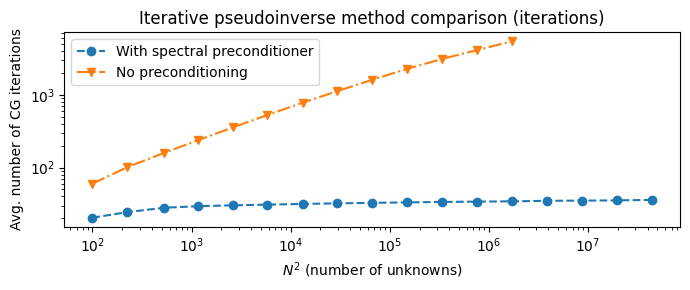

In [11]:
plt.figure(figsize=(7,3))
plt.loglog(N1s**2, preconditioned_mean_cg_its, label="With spectral preconditioner", ls="dashed", marker="o")
plt.loglog(N2s**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
plt.ylabel("Avg. number of CG iterations")
plt.xlabel("$N^2$ (number of unknowns)")
plt.title("Iterative pseudoinverse method comparison (iterations)")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
linregress(np.log(N1s**2), np.log(preconditioned_mean_cg_its))

LinregressResult(slope=0.031051204258445438, intercept=3.0963516933048076, rvalue=0.863546362143994, pvalue=7.979192344129845e-06, stderr=0.004681767254175391, intercept_stderr=0.05524672192957763)

In [13]:
linregress(np.log(N2s**2), np.log(mean_cg_its))

LinregressResult(slope=0.46111929249878525, intercept=2.177582600042543, rvalue=0.9972808340806281, pvalue=8.207270626601599e-14, stderr=0.010273937014318318, intercept_stderr=0.10232573357441169)

## Timing experiment

### With preconditioning

In [14]:
cp.random.seed(0)

preconditioned_time_costs_cpu = []
preconditioned_time_costs_gpu = []

# Iterate over N
for N in N1s:
    
    print(N)
    
    times_per_eval_cpu = []
    times_per_eval_gpu = []
    for j in range(N_SAMPLES):
        
        w = cp.random.uniform(low=LOW, high=HIGH, size=2*N*N)
        Apinv = jlinops.CGWeightedNeumann2DPinvOperator((N,N), 1.0/np.sqrt(w) , tol=TOL)
        Apinv = Apinv.to_gpu()
        R = Neumann2D((N,N), device="gpu")
        WR = DiagonalOperator(1.0/np.sqrt(w)) @ R 
        v = cp.random.normal(size=2*N*N)

        # Timing setup
        start_gpu = cp.cuda.Event()
        end_gpu = cp.cuda.Event()
        start_gpu.record()
        start_cpu = time.perf_counter()

        # Execute code
        _ = cupy_cg(Apinv.Rwpinv.C, Apinv.Rwpinv.A.T @ v, M=Apinv.Rwpinv.Mpinv, tol=TOL)
        
        # Compute time elapsed
        end_cpu = time.perf_counter()
        end_gpu.record()
        end_gpu.synchronize()
        t_gpu = cp.cuda.get_elapsed_time(start_gpu, end_gpu)
        t_gpu *= 0.001 # convert to seconds
        t_cpu = end_cpu - start_cpu
        
        times_per_eval_cpu.append(t_cpu)
        times_per_eval_gpu.append(t_gpu)
        
    preconditioned_time_costs_cpu.append(np.mean(times_per_eval_cpu))
    preconditioned_time_costs_gpu.append(np.mean(times_per_eval_gpu))

10
15
23
34
51
76
115
172
258
387
582
873
1311
1968
2955
4437
6661


In [15]:
preconditioned_time_costs_cpu

[0.03967372041195631,
 0.047322963029146195,
 0.05457276828587055,
 0.05734625678509474,
 0.05970869854092598,
 0.06006722345948219,
 0.06160798501223326,
 0.0637063830718398,
 0.0673800102621317,
 0.06638603828847409,
 0.06738232914358377,
 0.06836118400096894,
 0.1408455953374505,
 0.31090621966868637,
 1.043936494141817,
 1.6679088768735528,
 6.069191226959228]

In [16]:
preconditioned_time_costs_gpu

[0.039678123016357425,
 0.047326878890991214,
 0.054576826324462896,
 0.057350578613281245,
 0.05971301048278808,
 0.060071077804565436,
 0.06161205650329591,
 0.06371034049987792,
 0.06738400489807128,
 0.06638230850219727,
 0.06736481628417969,
 0.06766990264892579,
 0.1325829847717285,
 0.28499666259765627,
 0.9506643762207031,
 1.507022333984375,
 5.525361435546874]

### No preconditioning

In [ ]:
cp.random.seed(0)

time_costs_cpu = []
time_costs_gpu = []

# Iterate over N
for N in N2s:
    
    print(N)
    
    times_per_eval = []
    for j in range(N_SAMPLES):
        
        w = cp.random.uniform(low=LOW, high=HIGH, size=2*N*N)
        Apinv = jlinops.CGWeightedNeumann2DPinvOperator((N,N), 1.0/np.sqrt(w) , tol=TOL)
        Apinv = Apinv.to_gpu()
        R = Neumann2D((N,N), device="gpu")
        WR = DiagonalOperator(1.0/np.sqrt(w)) @ R 
        v = cp.random.normal(size=2*N*N)

        # Timing setup
        start_gpu = cp.cuda.Event()
        end_gpu = cp.cuda.Event()
        start_gpu.record()
        start_cpu = time.perf_counter()

        # Execute code
        _ = cupy_cg(Apinv.Rwpinv.C, Apinv.Rwpinv.A.T @ v, tol=TOL)
        
        # Compute time elapsed
        end_cpu = time.perf_counter()
        end_gpu.record()
        end_gpu.synchronize()
        t_gpu = cp.cuda.get_elapsed_time(start_gpu, end_gpu)
        t_gpu *= 0.001 # convert to seconds
        t_cpu = end_cpu - start_cpu
        
        times_per_eval_cpu.append(t_cpu)
        times_per_eval_gpu.append(t_gpu)
        
    time_costs_cpu.append(np.mean(times_per_eval_cpu))
    time_costs_gpu.append(np.mean(times_per_eval_gpu))

In [ ]:
time_costs_gpu

In [ ]:
time_costs_cpu

#### Also do banded cholesky?

In [20]:
# N = 300

# delta = 1e-5
# w = np.random.uniform(low=1, high=5, size=2*N*N)
# Rmat = jlinops.build_neumann2d_sparse_matrix( (N,N) )
# Dw = sps.diags(w)
# Rtilde = sps.diags(1.0/np.sqrt(w)) @ Rmat
# Rtilde = jlinops.MatrixLinearOperator(Rtilde)
# Rtilde_pinv = jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-5)

In [19]:
chol_Ns = N1s[:8]
print(chol_Ns)

NameError: name 'N1s' is not defined

In [20]:
delta = 1e-5

np.random.seed(0)

chol_time_costs = []


# Iterate over N
for N in chol_Ns:
    
    print(N)
    # setup_code = f'''import numpy as np \nfrom scipy.sparse.linalg import cg as sp_cg \nimport jlinops \nN = {N} \ntol={tol} \nw = np.random.uniform(low=1, high=5, size=2*N*N)\nApinv = jlinops.CGWeightedNeumann2DPinvOperator((N,N), 1.0/np.sqrt(w) , tol=tol)\nv = np.random.normal(size=2*N*N)'''

    setup_code = f'''import numpy as np \nimport jlinops \nimport scipy.sparse as sps \nN = {N} \ndelta = {delta} \nw = np.random.uniform(low=1, high=5, size=2*N*N) \nRmat = jlinops.build_neumann2d_sparse_matrix( (N,N) ) \nDw = sps.diags(w) \nRtilde = sps.diags(1.0/np.sqrt(w)) @ Rmat \nRtilde = jlinops.MatrixLinearOperator(Rtilde)\nu=np.random.normal(size=2*N*N)'''
    test_code = f'''Rtilde_pinv = jlinops.BandedCholeskyPinvOperator(Rtilde, delta={delta}) \n_ = Rtilde_pinv @ u'''
    
    time_cost = timeit.timeit(stmt=test_code, setup=setup_code, number=N_SAMPLES)
    time_per = time_cost/N_SAMPLES
    chol_time_costs.append(time_per)
    

NameError: name 'chol_Ns' is not defined

In [23]:
chol_time_costs

[0.000989540070295334,
 0.0011719643324613572,
 0.0021665487438440323,
 0.00500086098909378,
 0.01570041324943304,
 0.05553594093769789,
 0.2200407861918211,
 1.0035580160468818]

# Save data for plotting

In [ ]:
import pickle

In [ ]:
data_dct = {
    "N1s": N1s,
    "N2s": N2s,
    "preconditioned_time_costs_cpu": preconditioned_time_costs_cpu,
    "preconditioned_time_costs_gpu": preconditioned_time_costs_gpu,
    "time_costs_cpu": time_costs_cpu,
    "time_costs_gpu": time_costs_gpu,
    "chol_Ns": chol_Ns,
    "chol_time_costs": chol_time_costs,
    "preconditioned_mean_cg_its": preconditioned_mean_cg_its, 
    "mean_cg_its": mean_cg_its,
}

In [ ]:
# Pickle the dictionary to a file
with open('data2.pickle', 'wb') as handle:
    pickle.dump(data_dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data and plot

In [3]:
# Unpickle the dictionary from the file
with open('data2.pickle', 'rb') as handle:
    data = pickle.load(handle)

# Now my_dict_loaded contains your original dictionary
print(data)

{'N1s': array([  10,   15,   23,   34,   51,   76,  115,  172,  258,  387,  582,
        873, 1311, 1968, 2955, 4437, 6661], dtype=int32), 'N2s': array([  10,   15,   23,   34,   51,   76,  115,  172,  258,  387,  582,
        873, 1311], dtype=int32), 'preconditioned_time_costs_cpu': [0.03967372041195631, 0.047322963029146195, 0.05457276828587055, 0.05734625678509474, 0.05970869854092598, 0.06006722345948219, 0.06160798501223326, 0.0637063830718398, 0.0673800102621317, 0.06638603828847409, 0.06738232914358377, 0.06836118400096894, 0.1408455953374505, 0.31090621966868637, 1.043936494141817, 1.6679088768735528, 6.069191226959228], 'preconditioned_time_costs_gpu': [0.039678123016357425, 0.047326878890991214, 0.054576826324462896, 0.057350578613281245, 0.05971301048278808, 0.060071077804565436, 0.06161205650329591, 0.06371034049987792, 0.06738400489807128, 0.06638230850219727, 0.06736481628417969, 0.06766990264892579, 0.1325829847717285, 0.28499666259765627, 0.9506643762207031, 1.50702233

In [4]:
# Unpickle the dictionary from the file
with open('cpu_data.pickle', 'rb') as handle:
    datac = pickle.load(handle)

# Now my_dict_loaded contains your original dictionary
print(datac)

{'N1s': array([ 10,  15,  23,  34,  51,  76, 115, 172, 258, 387, 582], dtype=int32), 'N2s': array([ 10,  15,  23,  34,  51,  76, 115, 172, 258, 387, 582], dtype=int32), 'preconditioned_time_costs_cpu': [0.006246134259272367, 0.007108061658218503, 0.010577906699618325, 0.010431391940219328, 0.015682811861624943, 0.026677661860594525, 0.12386509314295836, 0.21046472295536658, 0.4181289246166125, 0.8223552600806578, 2.7064102344342973], 'time_costs_cpu': [1.3583185699151363, 0.9102687514348266, 0.6890374453659751, 0.5610335925973486, 0.4789311306489011, 0.43227006859312367, 0.47807522654373313, 0.6243484494097842, 1.010993230728549, 2.242430507624204, 6.453655846390272], 'chol_Ns': array([ 10,  15,  23,  34,  51,  76, 115, 172, 258, 387], dtype=int32), 'chol_time_costs': [0.004292368597816676, 0.0028369640989694745, 0.003816349996486679, 0.00833865330205299, 0.025439671595813708, 0.08559264540090225, 0.33082521819742394, 1.5291281532030552, 6.174991270602914, 38.997275576001265]}


In [5]:
data.keys()

dict_keys(['N1s', 'N2s', 'preconditioned_time_costs_cpu', 'preconditioned_time_costs_gpu', 'time_costs_cpu', 'time_costs_gpu', 'chol_Ns', 'chol_time_costs', 'preconditioned_mean_cg_its', 'mean_cg_its'])

In [6]:
dcolors.keys()

dict_keys(['dartmouth_green', 'forest_green', 'river_blue', 'autumn_brown', 'bonfire_red', 'river_navy', 'spring_green', 'rich_spring_green', 'summer_yellow', 'bonfire_orange', 'tuck_orange', 'web_violet', 'midnight_black'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


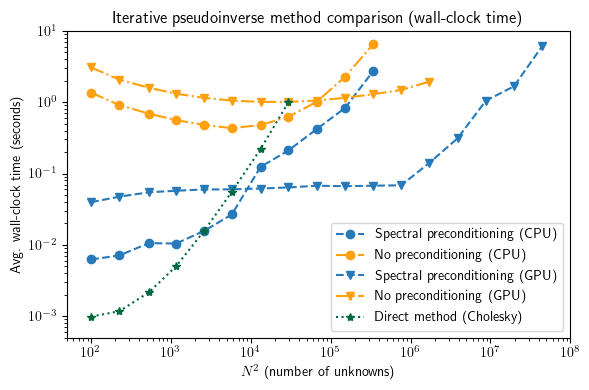

In [12]:
fig, axs = plt.subplots(1, figsize=(6,4))

axs.loglog(datac["N1s"]**2, datac["preconditioned_time_costs_cpu"], color=dcolors["river_blue"],label="Spectral preconditioning (CPU)", ls="dashed", marker="o")
axs.loglog(datac["N2s"]**2, datac["time_costs_cpu"], color=dcolors["bonfire_orange"], label="No preconditioning (CPU)", ls="dashdot", marker="o")

axs.loglog(data["N1s"]**2, data["preconditioned_time_costs_cpu"], color=dcolors["river_blue"],label="Spectral preconditioning (GPU)", ls="dashed", marker="v")
axs.loglog(data["N2s"]**2, data["time_costs_cpu"], color=dcolors["bonfire_orange"], label="No preconditioning (GPU)", ls="dashdot", marker="v")

axs.loglog(data["chol_Ns"]**2, data["chol_time_costs"], color=dcolors["dartmouth_green"], label="Direct method (Cholesky)", ls="dotted", marker="*")
axs.set_ylabel("Avg. wall-clock time (seconds)")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative pseudoinverse method comparison (wall-clock time)")
axs.legend()

axs.set_xlim(5*1e1, 1e8)
axs.set_ylim(5*1e-4, 1e1)

fig.tight_layout()

fig.savefig("lapinv_results_wallclock.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_results_wallclock.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


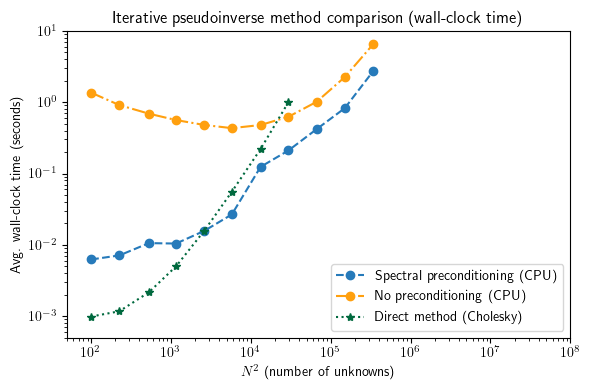

In [13]:
fig, axs = plt.subplots(1, figsize=(6,4))

axs.loglog(datac["N1s"]**2, datac["preconditioned_time_costs_cpu"], color=dcolors["river_blue"],label="Spectral preconditioning (CPU)", ls="dashed", marker="o")
axs.loglog(datac["N2s"]**2, datac["time_costs_cpu"], color=dcolors["bonfire_orange"], label="No preconditioning (CPU)", ls="dashdot", marker="o")

#axs.loglog(data["N1s"]**2, data["preconditioned_time_costs_cpu"], color=dcolors["river_blue"],label="Spectral preconditioning (GPU)", ls="dashed", marker="v")
#axs.loglog(data["N2s"]**2, data["time_costs_cpu"], color=dcolors["bonfire_orange"], label="No preconditioning (GPU)", ls="dashdot", marker="v")

axs.loglog(data["chol_Ns"]**2, data["chol_time_costs"], color=dcolors["dartmouth_green"], label="Direct method (Cholesky)", ls="dotted", marker="*")
axs.set_ylabel("Avg. wall-clock time (seconds)")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative pseudoinverse method comparison (wall-clock time)")
axs.legend()

axs.set_xlim(5*1e1, 1e8)
axs.set_ylim(5*1e-4, 1e1)

fig.tight_layout()

fig.savefig("lapinv_results_wallclock_cpu_only.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_results_wallclock_cpu_only.eps", bbox_inches="tight")


plt.show()

In [14]:
data.keys()

dict_keys(['N1s', 'N2s', 'preconditioned_time_costs_cpu', 'preconditioned_time_costs_gpu', 'time_costs_cpu', 'time_costs_gpu', 'chol_Ns', 'chol_time_costs', 'preconditioned_mean_cg_its', 'mean_cg_its'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


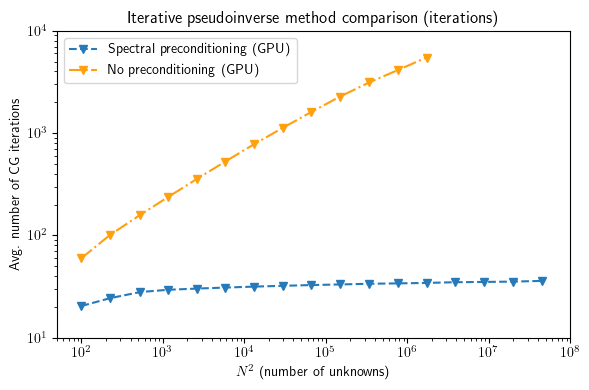

In [16]:
fig, axs = plt.subplots(1, figsize=(6,4))

axs.loglog(data["N1s"]**2, data["preconditioned_mean_cg_its"], color=dcolors["river_blue"],label="Spectral preconditioning (GPU)", ls="dashed", marker="v")
axs.loglog(data["N2s"]**2, data["mean_cg_its"], color=dcolors["bonfire_orange"], label="No preconditioning (GPU)", ls="dashdot", marker="v")


axs.set_ylabel("Avg. number of CG iterations")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative pseudoinverse method comparison (iterations)")
axs.legend()

axs.set_xlim(5*1e1, 1e8)
axs.set_ylim(1e1, 1e4)

fig.tight_layout()

fig.savefig("lapinv_results_iterations.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_results_iterations.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


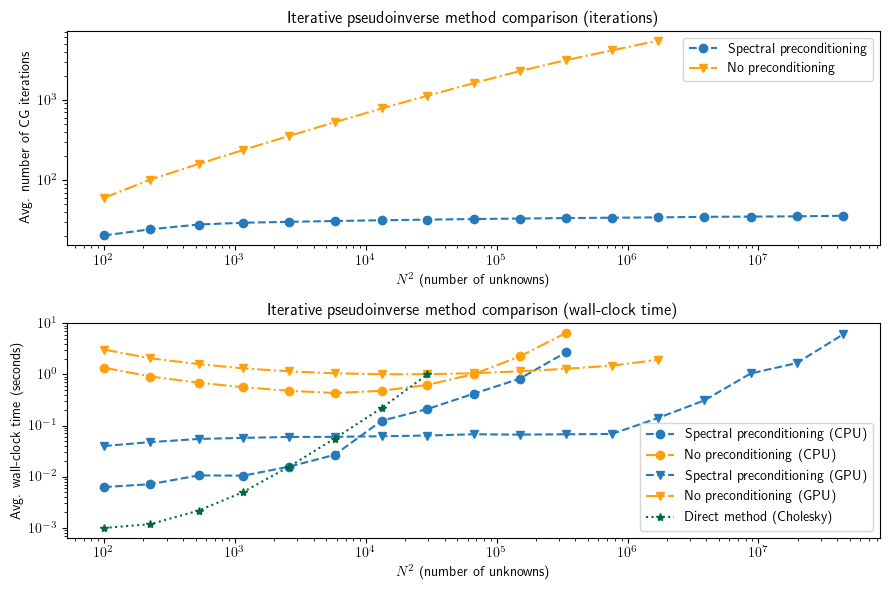

In [22]:
fig, axs = plt.subplots(2,1, figsize=(9,6))

axs[0].loglog(data["N1s"]**2, data["preconditioned_mean_cg_its"], label="Spectral preconditioning",  color=dcolors["river_blue"], ls="dashed", marker="o")
axs[0].loglog(data["N2s"]**2, data["mean_cg_its"], label="No preconditioning", color=dcolors["bonfire_orange"], ls="dashdot", marker="v")
axs[0].set_ylabel("Avg. number of CG iterations")
axs[0].set_xlabel("$N^2$ (number of unknowns)")
axs[0].set_title("Iterative pseudoinverse method comparison (iterations)")
axs[0].legend()


axs[1].loglog(datac["N1s"]**2, datac["preconditioned_time_costs_cpu"], color=dcolors["river_blue"],label="Spectral preconditioning (CPU)", ls="dashed", marker="o")
axs[1].loglog(datac["N2s"]**2, datac["time_costs_cpu"], color=dcolors["bonfire_orange"], label="No preconditioning (CPU)", ls="dashdot", marker="o")

axs[1].loglog(data["N1s"]**2, data["preconditioned_time_costs_cpu"], color=dcolors["river_blue"],label="Spectral preconditioning (GPU)", ls="dashed", marker="v")
axs[1].loglog(data["N2s"]**2, data["time_costs_cpu"], color=dcolors["bonfire_orange"], label="No preconditioning (GPU)", ls="dashdot", marker="v")

axs[1].loglog(data["chol_Ns"]**2, data["chol_time_costs"], color=dcolors["dartmouth_green"], label="Direct method (Cholesky)", ls="dotted", marker="*")
axs[1].set_ylabel("Avg. wall-clock time (seconds)")
axs[1].set_xlabel("$N^2$ (number of unknowns)")
axs[1].set_title("Iterative pseudoinverse method comparison (wall-clock time)")
axs[1].legend()



# axs[1].loglog(Ns**2, data["preconditioned_time_costs, label="Spectral preconditioning", ls="dashed", marker="o")
# axs[1].loglog(Ns**2, time_costs, label="No preconditioning", ls="dashdot", marker="v")
# axs[1].loglog(chol_Ns**2, chol_time_costs, label="Direct method (Cholesky)", ls="dotted", marker="*")
# axs[1].set_ylabel("Avg. wall-clock time (seconds)")
# axs[1].set_xlabel("$N^2$ (number of unknowns)")
# axs[1].set_title("Iterative pseudoinverse method comparison (wall-clock time)")
# axs[1].legend()


fig.tight_layout()

fig.savefig("lapinv_results.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_results.eps", bbox_inches="tight")


plt.show()

# Old plotting code

In [106]:
#Ns = np.asarray(Ns)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


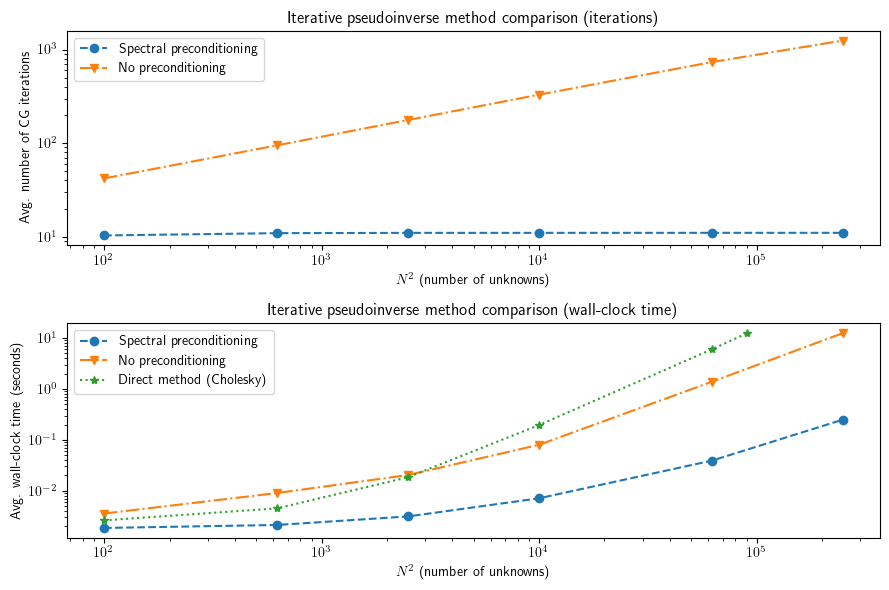

In [145]:
fig, axs = plt.subplots(2,1, figsize=(9,6))

axs[0].loglog(Ns**2, preconditioned_mean_cg_its, label="Spectral preconditioning", ls="dashed", marker="o")
axs[0].loglog(Ns**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
axs[0].set_ylabel("Avg. number of CG iterations")
axs[0].set_xlabel("$N^2$ (number of unknowns)")
axs[0].set_title("Iterative pseudoinverse method comparison (iterations)")
axs[0].legend()


axs[1].loglog(Ns**2, preconditioned_time_costs, label="Spectral preconditioning", ls="dashed", marker="o")
axs[1].loglog(Ns**2, time_costs, label="No preconditioning", ls="dashdot", marker="v")
axs[1].loglog(chol_Ns**2, chol_time_costs, label="Direct method (Cholesky)", ls="dotted", marker="*")
axs[1].set_ylabel("Avg. wall-clock time (seconds)")
axs[1].set_xlabel("$N^2$ (number of unknowns)")
axs[1].set_title("Iterative pseudoinverse method comparison (wall-clock time)")
axs[1].legend()


fig.tight_layout()

fig.savefig("lapinv_results.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_results.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


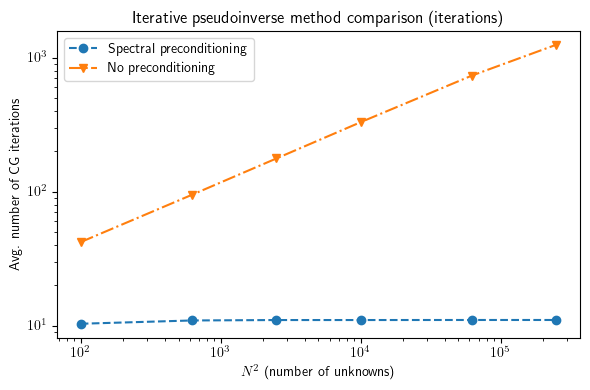

In [149]:
fig, axs = plt.subplots(1, figsize=(6,4))

axs.loglog(Ns**2, preconditioned_mean_cg_its, label="Spectral preconditioning", ls="dashed", marker="o")
axs.loglog(Ns**2, mean_cg_its, label="No preconditioning", ls="dashdot", marker="v")
axs.set_ylabel("Avg. number of CG iterations")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative pseudoinverse method comparison (iterations)")
axs.legend()


fig.tight_layout()

fig.savefig("lapinv_results_iterations.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_results_iterations.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


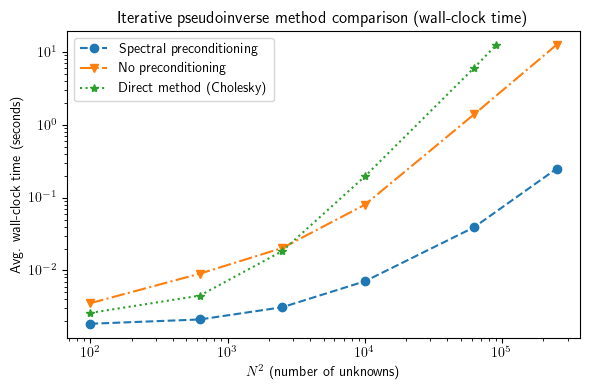

In [150]:
fig, axs = plt.subplots(1, figsize=(6,4))



axs.loglog(Ns**2, preconditioned_time_costs, label="Spectral preconditioning", ls="dashed", marker="o")
axs.loglog(Ns**2, time_costs, label="No preconditioning", ls="dashdot", marker="v")
axs.loglog(chol_Ns**2, chol_time_costs, label="Direct method (Cholesky)", ls="dotted", marker="*")
axs.set_ylabel("Avg. wall-clock time (seconds)")
axs.set_xlabel("$N^2$ (number of unknowns)")
axs.set_title("Iterative pseudoinverse method comparison (wall-clock time)")
axs.legend()


fig.tight_layout()

fig.savefig("lapinv_results_wallclock.png", dpi=250, bbox_inches="tight")
fig.savefig("lapinv_results_wallclock.eps", bbox_inches="tight")


plt.show()